In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.image as im
%matplotlib inline
import tensorflow as tf
import time
from datetime import timedelta
import math
import csv

training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = (X_train.shape[1],X_train.shape[2])
n_classes = len(np.unique(y_train))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


In [3]:
#############################################
tf.__version__

'0.11.0rc2'

In [4]:
y_train_one_hot = np.zeros((n_train,n_classes))
for i in range(0,n_train):
    y_train_one_hot[i,y_train[i]]=1
X_train = (0.2989*X_train[:,:,:,0]+0.5870*X_train[:,:,:,1]+0.1140*X_train[:,:,:,2])

y_test_one_hot = np.zeros((n_test,n_classes))
for i in range(0,n_test):
    y_test_one_hot[i,y_test[i]]=1
X_test = (0.2989*X_test[:,:,:,0]+0.5870*X_test[:,:,:,1]+0.1140*X_test[:,:,:,2])

In [5]:
#############################################
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 64             # Number of neurons in fully-connected layer.

#############################################
# 32x32
img_size = X_train.shape[1]
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = n_classes

#############################################
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

#############################################
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

#############################################
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

#############################################
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

#############################################
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [6]:
#############################################
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 16, 16, 16) dtype=float32>

In [7]:
#############################################
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 8, 8, 36) dtype=float32>

In [8]:
#############################################
layer_flat, num_features = flatten_layer(layer_conv2)
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2304) dtype=float32>

In [9]:
#############################################
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 64) dtype=float32>

In [10]:
#############################################
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 43) dtype=float32>

In [11]:
#############################################
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [12]:
#############################################
#optimizer = tf.train.AdagradOptimizer(learning_rate=0.01).minimize(cost)
optimizer = tf.train.FtrlOptimizer(learning_rate=0.01,l2_regularization_strength=1.0).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [13]:
#############################################
session = tf.Session()
session.run(tf.initialize_all_variables())
train_batch_size = 250

# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()
    for i in range(total_iterations,total_iterations + num_iterations):
        tmpp = np.unique(np.sort(np.random.randint(0,n_train,size=train_batch_size)))
        x_batch  = X_train[tmpp,:,:]        
        y_true_batch = y_train_one_hot[tmpp,:]        
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        acc = session.run(accuracy, feed_dict=feed_dict_train)
        msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
        print(msg.format(i + 1, acc))
        if (acc > 0.9999):
            break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [14]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [15]:
#Check to see if everything works OK
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   4.0%
Time usage: 0:00:01


In [ ]:
#RUN RUN RUN!!!
optimize(num_iterations=10000)

In [17]:
allImages = np.zeros((256,32,32,3))
for i in range(0,256):
    a=im.imread("web-images/"+str(i)+"compressed.jpg")
    allImages[i,:,:,:]=a

allImages = (0.2989*allImages[:,:,:,0]+0.5870*allImages[:,:,:,1]+0.1140*allImages[:,:,:,2])
feed_dict_test = {x: allImages,
                  y_true: np.zeros((256,43)),
                  y_true_cls: np.zeros((256,))}

f = open('signnames.csv')
csv_f = csv.reader(f)
SignDesc = []
for row in csv_f:
  SignDesc.append(row)
SignDesc=SignDesc[1:]

Matching Example #19. Best Guess: Ahead only


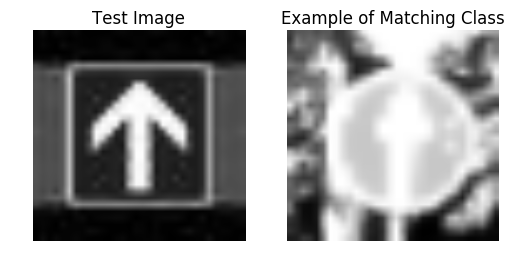

Matching Example #102. Best Guess: Dangerous curve to the left


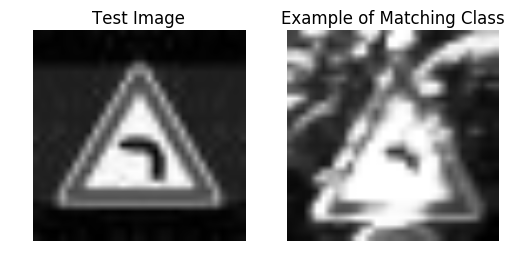

Matching Example #111. Best Guess: Double curve


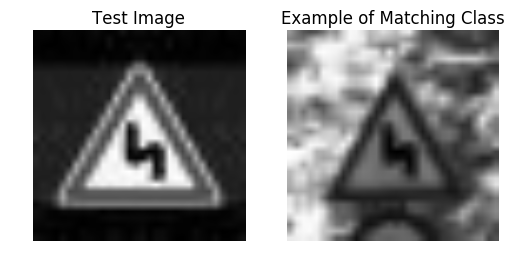

Matching Example #116. Best Guess: Bumpy road


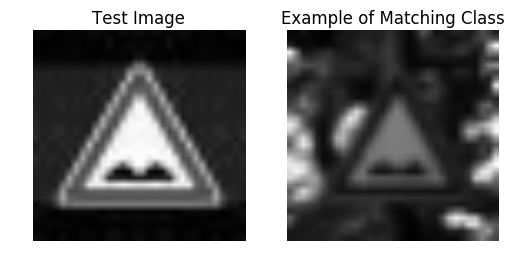

Matching Example #155. Best Guess: Stop


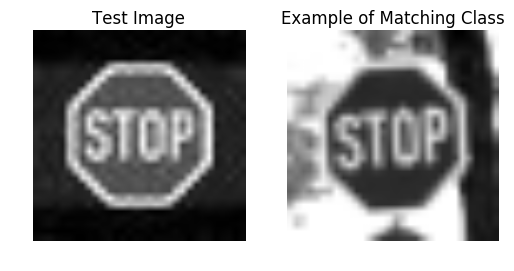

In [47]:
zzr = session.run(y_pred_cls,feed_dict=feed_dict_test)
tmp,example_images = np.unique(y_train,return_index=True)

matches = np.array([19, 102, 111, 116, 155])
for i in matches:
    zzra=zzr[i].astype(int)
    print('Matching Example #'+str(i)+'. Best Guess: '+SignDesc[zzra][1])

    plt.subplot(1,2,1)
    plt.imshow(allImages[i,:,:],'gray')
    plt.title('Test Image')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(X_train[example_images[zzr[i]]],'gray')
    plt.title('Example of Matching Class')
    plt.axis('off')
    plt.show()

Top five guesses for this image:
#1 Go straight or right
#2 Speed limit (60km/h)
#3 Turn left ahead
#4 Ahead only
#5 No passing


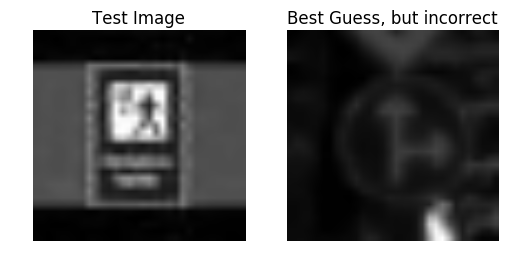

Top five guesses for this image:
#1 Right-of-way at the next intersection
#2 General caution
#3 Wild animals crossing
#4 Road work
#5 Double curve


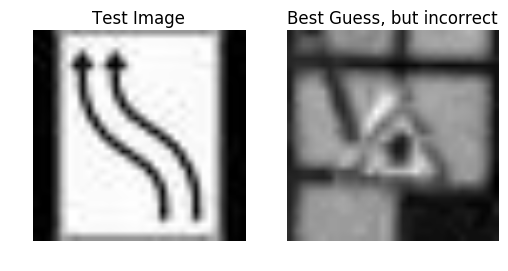

Top five guesses for this image:
#1 Right-of-way at the next intersection
#2 Road narrows on the right
#3 Roundabout mandatory
#4 Road work
#5 General caution


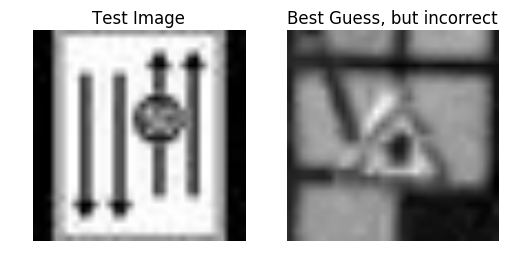

Top five guesses for this image:
#1 Beware of ice/snow
#2 Double curve
#3 Road narrows on the right
#4 Right-of-way at the next intersection
#5 Road work


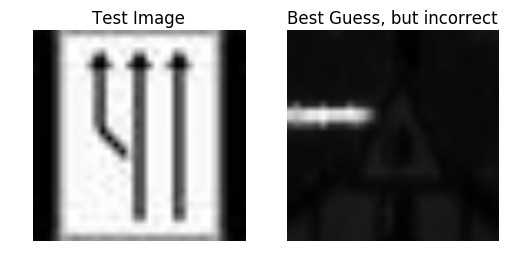

Top five guesses for this image:
#1 Stop
#2 Keep right
#3 No vechiles
#4 Roundabout mandatory
#5 Traffic signals


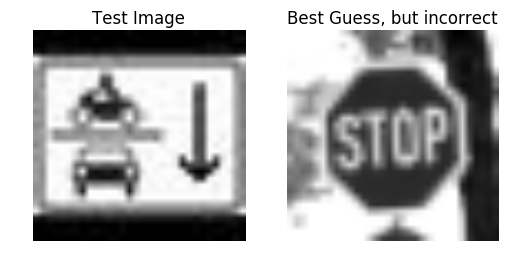

In [48]:
zzr = session.run(y_pred,feed_dict=feed_dict_test)
nonmatches = np.array([20, 40, 60, 80, 100])

for i in nonmatches:
    zzra = np.argsort(zzr[i,:])[-5:]
    print('Top five guesses for this image:')
    for j in range(len(zzra)):
        print('#'+str(j+1)+' '+SignDesc[zzra[j]][1])
        
    plt.subplot(1,2,1)
    plt.imshow(allImages[i,:,:],'gray')
    plt.title('Test Image')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(X_train[example_images[zzra[0]]],'gray')
    plt.title('Best Guess, but incorrect')
    plt.axis('off')
    plt.show()


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I downloaded 257 images of traffic signs from the web. I tested them on the model and it generally did fine.

If the model had been trained on a particular class, it could recognize it.

If the model had never seen a type of sign before (class not included in training), it could not recognize it.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

No, my accuracy on the test set is anywhere between 89-92% and the accuracy on the "external" web images is more close to 10%. Here is an explanation of what happened: 

The test accuracy fluctuates because of the randomness of the whole network, but usually ends up in the low 90s%.

The external test images are 257 images of traffic signs from the web. All images were pre-processed by first making them square and then shriking them to 32x32. However, only about ~30 of them belong to the 44 classes in the training set. The model is able to classify about 25 of those correctly... which is about 10%

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
See above, I have listed the top five guesses for a few incorrect images. For these test cases, the class is unknown, so no guess is really correct.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

See included file: get_web_test_images.ipynb

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.